In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
import myfunc as mf

import pandas as pd

In [2]:
x_data = {
    'x1': [15.64, 14.29, 15.39, 16.49, 15.03, 16.08, 14.78, 15.48, 14.00, 14.67],
    'x2': [15.33, 16.71, 16.26, 16.38, 14.69, 15.73, 16.06, 14.90, 16.91, 16.98],
    'x3': [17.72, 17.65, 17.57, 18.65, 17.95, 17.89, 17.29, 17.61, 18.46, 18.30] }

y_data = {
    'y1': [22.73, 21.00, 22.42, 25.33, 21.79, 26.72, 21.09, 21.11, 17.96, 20.43],
    'y2': [22.03, 21.18, 19.14, 24.67, 24.54, 24.05, 25.85, 22.78, 25.78, 26.29],
    'y3': [22.70, 23.09, 22.77, 23.78, 23.12, 22.27, 20.41, 22.62, 24.83, 23.24]
}

# Create DataFrame
datax = pd.DataFrame(x_data)
datay=pd.DataFrame(y_data)
datax.head()
datay.head()


,y1,y2,y3
0,22.73,22.03,22.70
1,21.00,21.18,23.09
2,22.42,19.14,22.77
3,25.33,24.67,23.78
4,21.79,24.54,23.12


Design a control chart for the mean, assuming that the variance-covariance matrix is known 
(ARL0=100): 
SIGMA =  [2,45 1,12  
1,12 4,92] 

In [3]:
alpha_fam=1/100
alpha_single=alpha_fam/2

S = pd.DataFrame([[2.45, 1.12],
                [1.12, 4.92]])


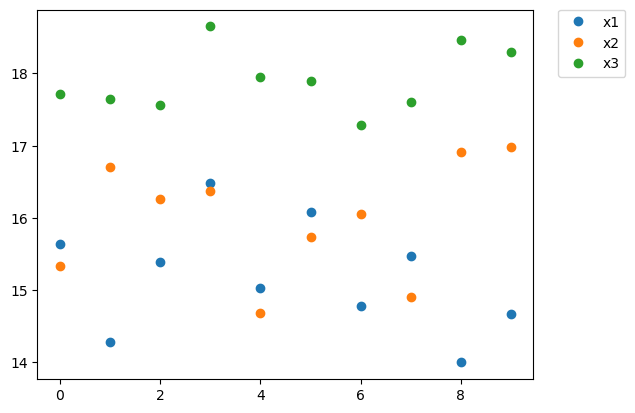

In [4]:
mf.dotplot(datax) 
#nelle soluzioni si fa finta di niente (x3 è sempre palesemente più grande)

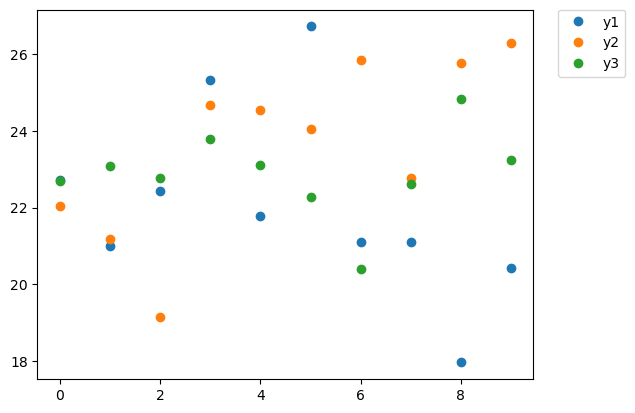

In [5]:
mf.dotplot(datay)

p-value of the Shapiro-Wilk test: 0.32949
Accept H0: the data are normal


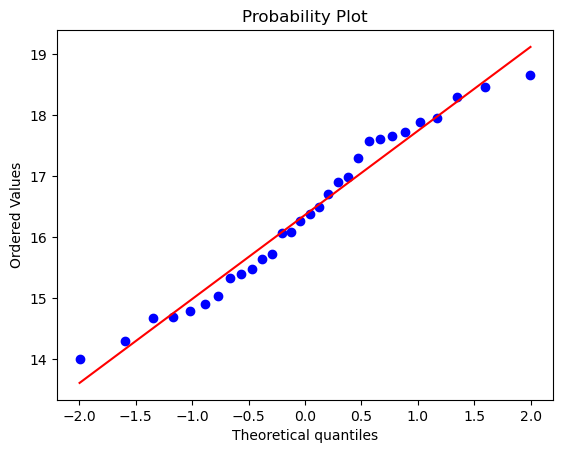

In [6]:
mf.shapiroqq(datax,0.05,'yes')

p-value of the Shapiro-Wilk test: 0.86993
Accept H0: the data are normal


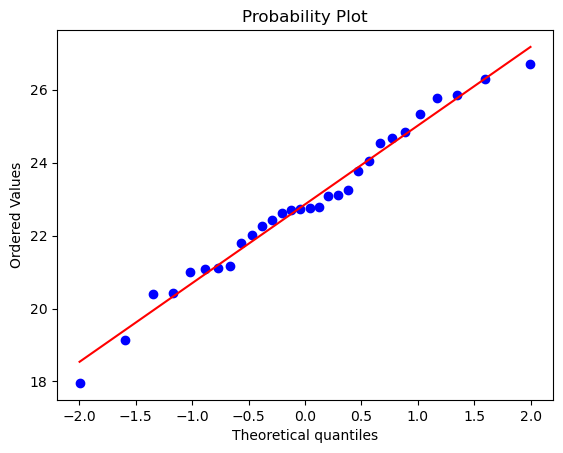

In [7]:
mf.shapiroqq(datay,0.05,'yes')

In [8]:
sample_mean = pd.DataFrame()
#devo calcolare una media per ogni riga (ogni sample) per ottenere il vettore delle medie, ossia si opera la media lungo le colonne
sample_mean['x1'] = datax.mean(axis=1) #si lavora con i sample mean vectors!!!
#faccio la stessa cosa per l'altra variabile:
sample_mean['x2'] = datay.mean(axis=1)

# Calculate the grand mean
Xbarbar = sample_mean.mean() #
print(Xbarbar)


x1    16.363000
x2    22.857333
dtype: float64


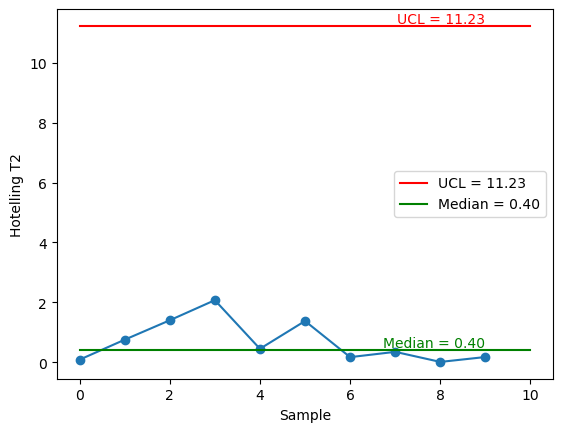

In [9]:
[UCL,T2]=mf.HotCC_phase1(2,len(sample_mean),3,alpha_fam, sample_mean,Xbarbar,S,quanti_sample_levati=0)

Design a control chart for the linear combination of the sample means of the two variables 
that maximises the amount of explained variability, with ARL0=100. Specify the weights of 
the linear combination. Hint: use, for your analysis, the correlation matrix of the sample 
means. 

In [10]:
data_stack = pd.DataFrame()
data_stack[['sample', 'x']] = datax.transpose().melt()
data_stack['y'] = datay.transpose().melt()['value'] 
#eg. Se ce ne fosse un’altra:
# data_stack['glide'] = glide.transpose().melt()['value']
#quello che otteniamo è sostanzialmente un dataframe composto da covariance matrices che tecnicamente è un multi-indexed dataframe 
cov_matrix = data_stack.groupby('sample').cov()
#print(type(cov_matrix))
cov_matrix.head(8)
S = cov_matrix.groupby(level=1).mean()
cols = S.columns.tolist()
S = S.reindex(columns=cols, index=cols)
print(S)


          x        y
x  2.420673  1.11461
y  1.114610  4.94537


In [11]:
S2=sample_mean.corr()
print(S2)

          x1        x2
x1  1.000000  0.637731
x2  0.637731  1.000000


In [12]:
[pca,scores_df]=mf.p_pca(sample_mean, len(sample_mean), standardize='yes')

Eigenvalues 
 [1.6377313 0.3622687]

Eigenvectors aka Loadings 
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

Explained variance ratio 
 [0.81886565 0.18113435]

Cumulative explained variance ratio 
 [0.81886565 1.        ]
first 5 rows of the df scores:
         z1        z2
0 -0.503236 -0.006498
1 -1.030077 -0.483541
2 -0.890710 -1.053799
3  2.706906 -0.319588
4 -0.682063  1.084533


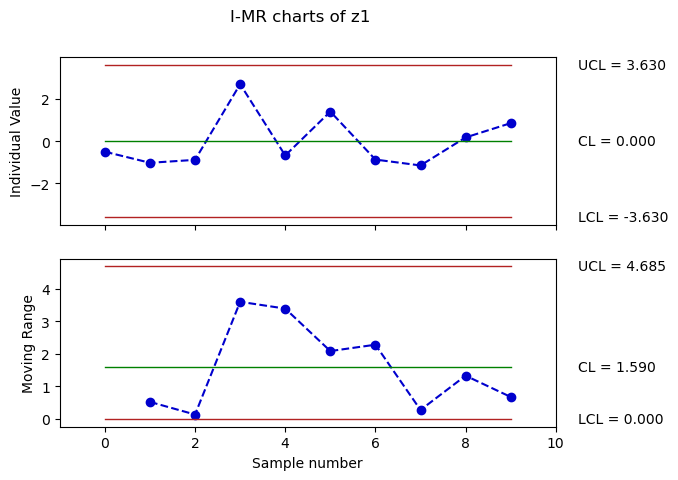

In [13]:
k=stats.norm.ppf(1-alpha_fam/2)
data_IMR = qda.ControlCharts.IMR(scores_df, 'z1',K=k) #specifica nome colonna dei dati

What is the average number of samples one has to wait before the chart designed at point 3 
signals a shift of the mean equal to 1.5 units of standard deviation? 

mi stanno chiedendo il beta dell'I control chart (fatto sulle medie qui) per la media che shifta 1.5 stdev volte quella usata per il CC.
in pratica mi stanno chiedendo il beta di un Xbar CC con n=1 con quello shift della media

In [14]:
sigma_estimate=data_IMR['MR'].mean()/qda.constants.getd2(2) #inutile qui perchè uso delta_piccolo ma va be
delta_piccolo=1.5

beta=stats.norm.cdf(k-delta_piccolo*np.sqrt(1))-stats.norm.cdf(-k-delta_piccolo*np.sqrt(1))
print(beta)
ARL=1/(1-beta)
print(ARL)

0.8589752725731629
7.0909550278605895


In [5]:
sample_mean = {'x1': [2, 1, 1],
        'x2': [0, 1, -1],
        'x3': [0, -1, 0],
       }

sample_mean=pd.DataFrame(sample_mean)

Sigma = pd.DataFrame([[1, 0.9,0.9],
                [0.9,1,0.9],
                [0.9,0.9,1]],
                columns=['x1', 'x2','x3'],
                index=['x1', 'x2','x3'])

mu = pd.Series({'x1': 0, 'x2': 0, 'x3': 0})

In [6]:
d=mf.calculate_d(sample_mean, mu, Sigma)